# Molecular Isotopic Distributions Part 1: Enumerating Isotopic Placements

Elements can have several [isotopes](https://en.wikipedia.org/wiki/Isotope), which have the same number of protons and neutrons but different numbers of neutrons. Because a neutron has a mass of approximately 1 amu (atomic mass unit), different isotopes of an element appear at different masses in a mass spectrum as measured by a mass spectrometer.

Different elements have different isotopes and different natural abundances, meaning the percent of each isotope that is found in nature. For example, [carbon has two stable isotopes](https://en.wikipedia.org/wiki/Isotopes_of_carbon), <sup>12</sup>C with 98.9% natural abundance and <sup>13</sup>C with 1.06% natural abundance. As another example, [oxygen has three stable isotopes](https://en.wikipedia.org/wiki/Isotopes_of_oxygen), <sup>16</sup>O with 99.8% natural abundance, <sup>17</sup>O with 0.0380% natural abundance, and <sup>18</sup>O with 0.205% natural abundance. The distribution of isotopes thus forms a fingerprint for an element. As another example, [chlorine has two stable isotopes with significant natural abundance](https://en.wikipedia.org/wiki/Isotopes_of_chlorine), <sup>35</sup>Cl with 76% natural abundance, and <sup>37</sup>O with 24% natural abundance. The distribution of isotopes thus forms a fingerprint for an element. 

When atoms combine into molecules, the mass distributions get richer. For example, in the diatomic molecule chlorine Cl<sub>2</sub>, which has two chlorine atoms, there are three possible molecular isotopes:

In [76]:
# !pip install rdkit
# !pip install mendeleev

In [77]:
from collections import defaultdict
import math
import hashlib
import json

import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

from mendeleev import element
from rdkit import Chem
from rdkit.Chem import Descriptors

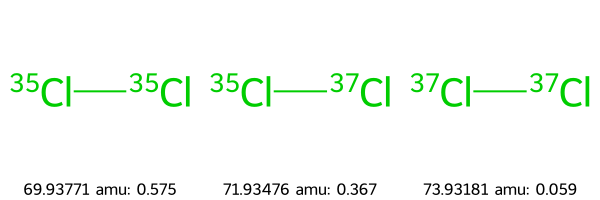

In [120]:
chlorine_smls = ["[35Cl][35Cl]", "[35Cl][37Cl]", "[37Cl][37Cl]"]
chlorine_mols = [Chem.MolFromSmiles(sml) for sml in chlorine_smls]
chlorine_masses = [Descriptors.ExactMolWt(mol) for mol in chlorine_mols]
chlorine_abundances = [0.574564, 0.366872, 0.058564]
legends = [f"{mass:.5f} amu: {abundance:.3f}" for mass, abundance in zip(chlorine_masses, chlorine_abundances)]
legends
Chem.Draw.MolsToGridImage(chlorine_mols, legends=legends)

The molecule <sup>35</sup>Cl<sup>37</sup>Cl in the middle, with mixed isotopes, represents two possible placements of the isotopes: it is equivalent to <sup>37</sup>Cl<sup>35</sup>Cl because the order of the chlorine atoms is not significant due to symmetry.

In part 1, I use the naive method of creating a molecule for each possible arrangement of isotopes ([permutation](https://en.wikipedia.org/wiki/Permutation)) of a molecule. I hazily recalled that I could enumerate the [combinations](https://en.wikipedia.org/wiki/Combination), where the order of the isotopes over the atoms in a molecule is disregarded, and calculate the permutations in each combination using the [binomial distribution](https://en.wikipedia.org/wiki/Binomial_distribution) to calculate the number of arrangements of a given number of each isotope ([isotopomer](https://en.wikipedia.org/wiki/Isotopomer)), but I decided to first try the approach that was easier to code. When I learned that became computationally infeasible for large molecules, I used the binomial distribution in part 2.

In [123]:
# sml = "C=C=O"

# Create a molecule object
# sml = "CCO"  # Example molecule: Ethanol (C2H5OH)

# Add explicit hydrogens
# Chem.AddHs(mol)

# sml = "ClC(Cl)Cl"

# Carbon tetrachloride; four Cl
# sml = "ClC(Cl)(Cl)Cl"

# sml = "c1ccccc1" # benzene; boring

# Calcium carbonate; boring
# sml = "[Ca+2].[O-]C([O-])=O"

# Potassium cyanide; three elements
# sml = "[K+].[C-]#N"

# FeCl3; good for distinguishing very similar masses
# sml = "Cl[Fe](Cl)Cl"

# Cl2; simple case
# sml = "ClCl"

# Buckminsterfullerene; computationally expensive!
# sml = "c12c3c4c5c2c2c6c7c1c1c8c3c3c9c4c4c%10c5c5c2c2c6c6c%11c7c1c1c7c8c3c3c8c9c4c4c9c%10c5c5c2c2c6c6c%11c1c1c7c3c3c8c4c4c9c5c2c2c6c1c3c42"

# Napthlene
sml = "c1ccc2c(c1)cccc2"

# Homo triatomic
# sml = "[O-][O+]=O"

# Homo diatomic
# sml = "O=O"

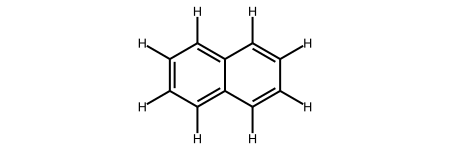

In [124]:
mol = Chem.AddHs(Chem.MolFromSmiles(sml))
mol

In [125]:
class MolecularIsotope():
  """Store a molecule's isotopic properties."""
  def __init__(
      self,
      sml: str,
      abundance: float = None):
    self.sml = sml
    self.abundance = abundance
    try:
      self.mol = Chem.AddHs(Chem.MolFromSmiles(sml))
    except:
      self.mol = Chem.AddHs(Chem.MolFromSmiles(sml, sanitize=False))
    self.mass = Descriptors.ExactMolWt(self.mol)
  def update(self):
    self.mass = Descriptors.ExactMolWt(self.mol)
    self.canon_sml = Chem.MolToSmiles(mol)

In [126]:
def element_set(molecule):
    """Get the set of elements in an RDKit molecule
    For example, ethanol (SMILES CCO, formula C2H5OH)
    returns {'C', 'O', 'H'}.

    :param molecule: An RDKit molecule
    :rtype: A dictionary.
    """
    # Check that there is a valid molecule
    if molecule:
      # Add hydrogen atoms--RDKit excludes them by default
      molecule_with_Hs = Chem.AddHs(molecule)
      atom_symbols = set(atom.GetSymbol() for atom in molecule_with_Hs.GetAtoms())
      return atom_symbols

In [127]:
set_of_elements = element_set(mol)
print(set_of_elements)
isotopes = {}
for element_symbol in set_of_elements:
  # print(f"{element=}")
  # print(f"{element(element)=}")
  element_isotopes = element(element_symbol).isotopes
  occurring_isotopes = [[isotope.mass_number, isotope.abundance/100] for isotope in element_isotopes if isotope.abundance != None]
  isotopes[element_symbol] = occurring_isotopes
print(isotopes)

{'C', 'H'}
{'C': [[12, 0.9894], [13, 0.0106]], 'H': [[1, 0.999855], [2, 0.000145]]}


In [128]:
num_atoms = len(mol.GetAtoms())

# Build iterable of number of isotopes by atom index
isotopes_by_atom_index = ()
for atom_index, atom in enumerate(mol.GetAtoms()):
  atom_symbol = atom.GetSymbol()
  isotopes_by_atom_index += (len(isotopes[atom_symbol]),)

In [129]:
def set_isotopes(arr:np.ndarray, sml: str, current_index=()):
    if isinstance(arr, np.ndarray):
        for i in range(len(arr)):
            arr[i] = set_isotopes(arr=arr[i], current_index=current_index + (i,), sml=sml)
        return arr
    else:
        # For an individual item in the ndarray, create molecule, 
        # set the isotopes of each of its atoms, and calculate abundance
        item = MolecularIsotope(sml=sml)
        mol = item.mol
        abundance = 1
        for atom_index, atom in enumerate(mol.GetAtoms()):
          atom_symbol = atom.GetSymbol()
          isotope_data_to_use = isotopes[atom_symbol][current_index[atom_index]]
          isotope_to_use = isotope_data_to_use[0]
          atom.SetIsotope(isotope_to_use)
          abundance *= isotope_data_to_use[1]
        item.update()
        item.abundance = abundance          
        return item

In [130]:
# Create the empty numpy ndarray with the specified shape
mol_isotopes = np.empty(isotopes_by_atom_index, dtype=object)

# Set the isotopes for each atom in each molecule
mol_isotopes = set_isotopes(arr = mol_isotopes, sml = sml, current_index=())

In [131]:
def composition(
        molecule,
        isotopes=False):
    """Get the composition of an RDKit molecule:
    Atomic counts, including hydrogen atoms, and any charge.
    For example, fluoride ion (chemical formula F-, SMILES string [F-])
    returns {9: 1, 0: -1}.

    :param molecule: The molecule to analyze
    :type some_input: An RDKit molecule
    :rtype: A dictionary.
    """
    # Check that there is a valid molecule
    if molecule:

        # Add hydrogen atoms--RDKit excludes them by default
        Chem.AddHs(molecule)
        comp = defaultdict(lambda: 0)

        # Get atom counts
        for atom in molecule.GetAtoms():
            element_symbol = atom.GetSymbol()
            if not isotopes:
                comp[element_symbol] += 1
            else:
                isotope = atom.GetIsotope()
                try:
                    comp[element_symbol][isotope] += 1
                except:
                    comp[element_symbol] = defaultdict(lambda: 0)
                    comp[element_symbol][isotope] += 1
        return comp

In [132]:
composition(mol, isotopes=True)

defaultdict(<function __main__.composition.<locals>.<lambda>()>,
            {'C': defaultdict(<function __main__.composition.<locals>.<lambda>()>,
                         {0: 10}),
             'H': defaultdict(<function __main__.composition.<locals>.<lambda>()>,
                         {0: 8})})

In [133]:
def flatten_ndarray(arr):
    flat_list = []
    for element in arr:
        if isinstance(element, np.ndarray):
            flat_list.extend(flatten_ndarray(element))
        else:
            flat_list.append(element)
    return flat_list

In [134]:
def binomial_coefficient(n, k):
    return math.factorial(n) // (math.factorial(k) * math.factorial(n - k))

In [135]:
def distribute_items(n, k):
    def backtrack(remaining_items, bins, current_bin):
        if current_bin == k:
            if remaining_items == 0:
                results.append(list(bins))
            return

        for items_in_current_bin in range(remaining_items + 1):
            bins[current_bin] = items_in_current_bin
            backtrack(remaining_items - items_in_current_bin, bins, current_bin + 1)

    results = []
    bins = [0] * k
    backtrack(n, bins, 0)
    return results

In [136]:
mol_isotopes_flat = flatten_ndarray(mol_isotopes)
mol_isotopes_flat.sort(key=lambda x:x.mass)

In [137]:
# Function to flatten nested defaultdict into a flat dictionary
def flatten_dict(d, parent_key='', sep='_'):
    items = []
    for k, v in d.items():
        new_key = f"{parent_key}{sep}{k}" if parent_key else k
        if isinstance(v, dict):
            items.extend(flatten_dict(v, new_key, sep=sep).items())
        else:
            items.append((new_key, v))
    return dict(items)

In [138]:
composition(mol_isotopes_flat[0].mol, isotopes=True)

defaultdict(<function __main__.composition.<locals>.<lambda>()>,
            {'C': defaultdict(<function __main__.composition.<locals>.<lambda>()>,
                         {12: 10}),
             'H': defaultdict(<function __main__.composition.<locals>.<lambda>()>,
                         {1: 8})})

In [139]:
def hash_dict(dict):
    json_str = json.dumps(dict, sort_keys=True)
    hashed_value = hashlib.sha256(json_str.encode()).hexdigest()
    return hashed_value

In [140]:
def hash_nested_dict(d):
    # Convert the nested dictionary to a JSON string with sorted keys
    json_str = json.dumps(d, sort_keys=True)

    # Hash the JSON string using a cryptographic hash function (e.g., SHA-256)
    hash_obj = hashlib.sha256()
    hash_obj.update(json_str.encode())
    return hash_obj.hexdigest()

In [141]:
import polars as pl
data_dict_list = []
for mol_isotope in mol_isotopes_flat:
    data_dict = {prop: getattr(mol_isotope, prop) for prop in vars(mol_isotope).keys()}
    data_dict["mol_isotope"] = mol_isotope
    composition_dict = composition(mol_isotope.mol, isotopes=True)
    hashed_composition_dict = hash_nested_dict(composition_dict)
    # flat_composition = flatten_dict(composition(mol_isotope.mol, isotopes=True))
    # sorted_flat_composition = {key: flat_composition[key] for key in sorted(flat_composition)}
    # hashed_flat_composition = hash_dict(flat_composition)
    data_dict["composition"] = str(hashed_composition_dict)
    data_dict_list.append(data_dict)
df = pl.DataFrame(data_dict_list)
df

sml,abundance,mol,mass,canon_sml,mol_isotope,composition
str,f64,object,f64,str,object,str
"""c1ccc2c(c1)ccc…",0.897874,<rdkit.Chem.rdchem.Mol object at 0x1639042e0>,128.0626,"""[H]c1c([H])c([…",<__main__.MolecularIsotope object at 0x168df0690>,"""bba1db7e32e072…"
"""c1ccc2c(c1)ccc…",0.009619,<rdkit.Chem.rdchem.Mol object at 0x16387d9a0>,129.065955,"""[H]c1c([H])c([…",<__main__.MolecularIsotope object at 0x168c0c990>,"""5233ab61242212…"
"""c1ccc2c(c1)ccc…",0.009619,<rdkit.Chem.rdchem.Mol object at 0x165bbeea0>,129.065955,"""[H]c1c([H])c([…",<__main__.MolecularIsotope object at 0x168c005d0>,"""5233ab61242212…"
"""c1ccc2c(c1)ccc…",0.009619,<rdkit.Chem.rdchem.Mol object at 0x165b5f290>,129.065955,"""[H]c1c([H])c([…",<__main__.MolecularIsotope object at 0x165b6a5d0>,"""5233ab61242212…"
"""c1ccc2c(c1)ccc…",0.009619,<rdkit.Chem.rdchem.Mol object at 0x1654fba70>,129.065955,"""[H]c1c([H])c([…",<__main__.MolecularIsotope object at 0x165cf4090>,"""5233ab61242212…"
"""c1ccc2c(c1)ccc…",0.009619,<rdkit.Chem.rdchem.Mol object at 0x165d1cac0>,129.065955,"""[H]c1c([H])c([…",<__main__.MolecularIsotope object at 0x1658e03d0>,"""5233ab61242212…"
"""c1ccc2c(c1)ccc…",0.009619,<rdkit.Chem.rdchem.Mol object at 0x1633b2a40>,129.065955,"""[H]c1c([H])c([…",<__main__.MolecularIsotope object at 0x1636c0150>,"""5233ab61242212…"
"""c1ccc2c(c1)ccc…",0.009619,<rdkit.Chem.rdchem.Mol object at 0x165c569d0>,129.065955,"""[H]c1c([H])c([…",<__main__.MolecularIsotope object at 0x165ca37d0>,"""5233ab61242212…"
"""c1ccc2c(c1)ccc…",0.009619,<rdkit.Chem.rdchem.Mol object at 0x28fafe8f0>,129.065955,"""[H]c1c([H])c([…",<__main__.MolecularIsotope object at 0x28faf1810>,"""5233ab61242212…"


In [142]:
for row in range(4):
    # print(df[row]["composition"].item())
    print(df[row]["mass"].item(), df[row]["composition"].item())
    # print(df[row]["mass"].item())

128.062600256 bba1db7e32e0722dae2dfcfb80be5bc848ba12583897438055b9707b77ddb052
129.065955096 5233ab61242212fa7bb7765a28c7c7f3870d9d4b1d674d7a61498389cac01165
129.065955096 5233ab61242212fa7bb7765a28c7c7f3870d9d4b1d674d7a61498389cac01165
129.065955096 5233ab61242212fa7bb7765a28c7c7f3870d9d4b1d674d7a61498389cac01165


In [143]:
agg_exprs = [
    pl.sum("abundance").alias("abundance")
] + [
    pl.col(col).first().alias(col)
    for col in df.columns
    if col not in ("composition", "abundance")
]
result_df = df.group_by("composition").agg(agg_exprs)

In [144]:
result_df = result_df.sort("mass")

It might be tempting to match molecules by mass, but a floating-point value can have some error or uncertainty. In some cases, the mass differences between different species can be quite small (for example less than 0.002 amu if the sum of the mass numbers is the same), so adding a tolerance risks lumping different molecules together. So it's best to use some discrete identifier. In this case, we use the SMILES, which contains isotope labels.

In [153]:
mol_isotopes_agg_rows = result_df.rows(named=True)
mol_isotopes_agg_mols = [row["mol"] for row in mol_isotopes_agg_rows]
mol_isotopes_agg_masses = [row["mass"] for row in mol_isotopes_agg_rows]
mol_isotopes_agg_abundances = [row["abundance"] for row in mol_isotopes_agg_rows]
legends = [f"{mass:.8f}: {abundance:.3e}" for mass, abundance in zip(mol_isotopes_agg_masses, mol_isotopes_agg_abundances)]
# legends = [f"{mass:.3f if abundance > 0.01 else mass:.3e}: {abundance:.3e}" for mass, abundance in zip(mol_isotopes_agg_masses, mol_isotopes_agg_abundances)]
# legends = [f"{mass:.3f}" if abundance > 0.01 else f"{mass:.3e}" for mass, abundance in zip(mol_isotopes_agg_masses, mol_isotopes_agg_abundances)]


/Users/jemonat/Projects/bertiewooster.github.io/venv/lib/python3.11/site-packages/rdkit/Chem/Draw/IPythonConsole.py:261: UserWarning: Truncating the list of molecules to be displayed to 50. Change the maxMols value to display more.
  warnings.warn(


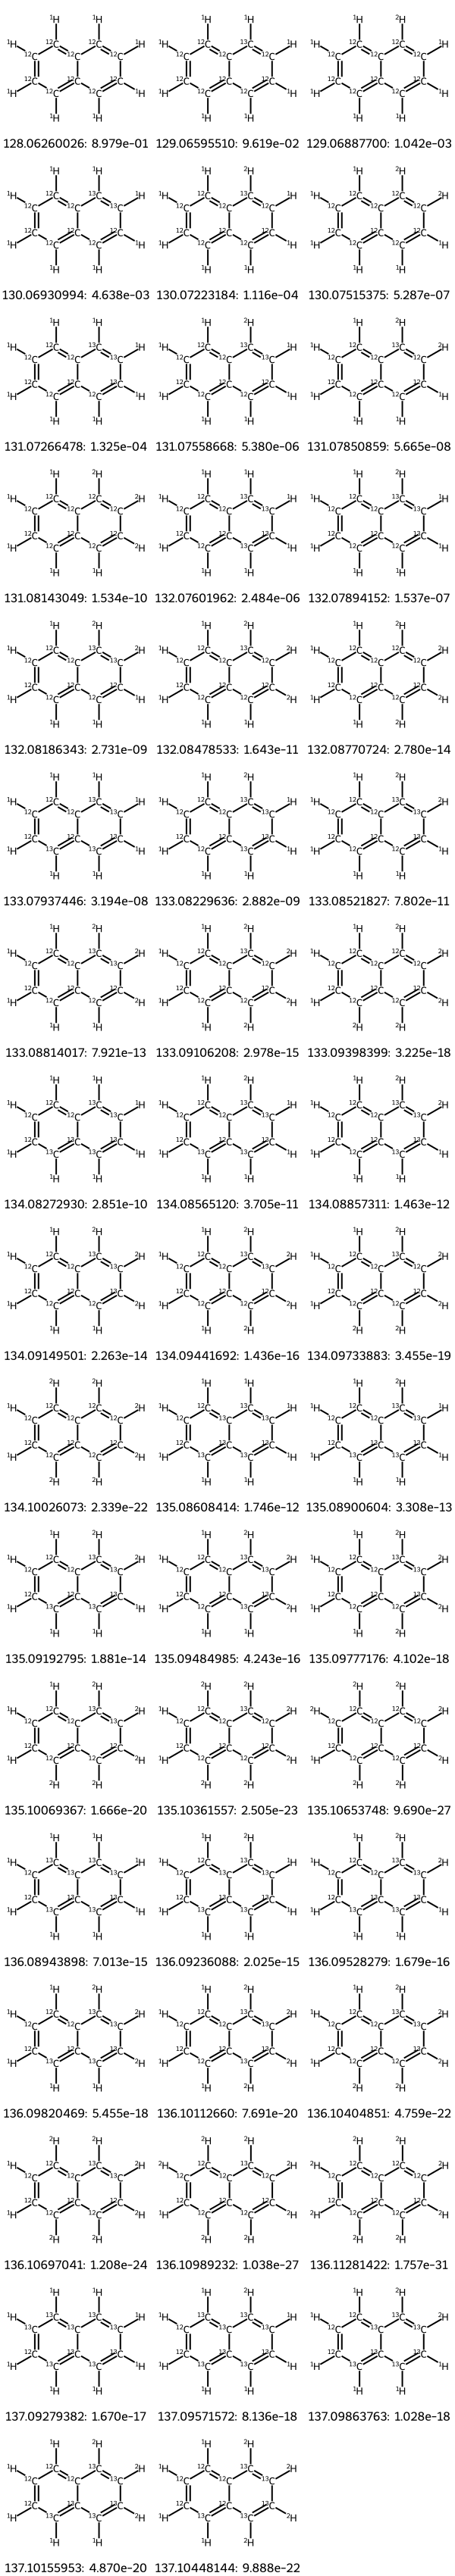

In [155]:
# Chem.Draw.MolsToGridImage(mols = mol_isotopes_agg_mols, legends = legends, maxMols=len(mol_isotopes_agg_rows))
Chem.Draw.MolsToGridImage(mols = mol_isotopes_agg_mols, legends = legends)

In [148]:
abundance_sum = sum(mol_isotopes_agg_abundances)
print(abundance_sum)

1.0


In [149]:
df_pandas_all = pd.DataFrame({
    'Mass': mol_isotopes_agg_masses,
    'Abundance': mol_isotopes_agg_abundances
})

In [150]:
df_pandas_all

,Mass,Abundance
0,128.062600,8.978737e-01
1,129.065955,9.619427e-02
2,129.068877,1.041685e-03
3,130.069310,4.637625e-03
4,130.072232,1.116015e-04
...,...,...
94,144.136731,1.801888e-43
95,144.139653,1.371978e-45
96,145.140086,1.930464e-46
97,145.143008,3.266395e-48


In [151]:
df_pandas = df_pandas_all.loc[df_pandas_all['Abundance'] >= 0.0000000000000001]

/Users/jemonat/Projects/bertiewooster.github.io/venv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jemonat/Projects/bertiewooster.github.io/venv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


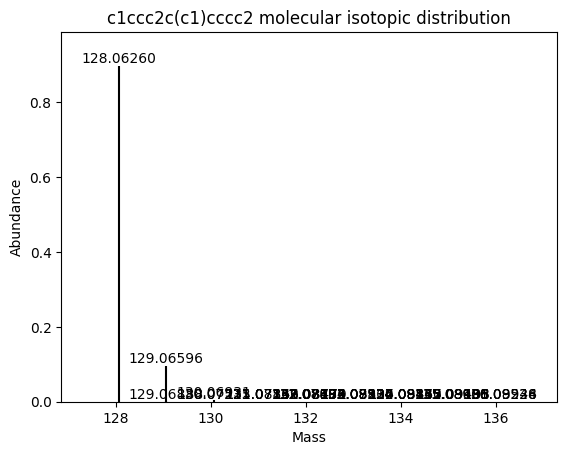

In [152]:
# Create the scatter plot using Seaborn
sns.scatterplot(x='Mass', y='Abundance', data=df_pandas, marker='')

plt.xlabel('Mass')
plt.ylabel('Abundance')
plt.title(f'{sml} molecular isotopic distribution')

# Adjust x-axis limits to allow more space on the left and right for labels
xrange = max(df_pandas['Mass']) - min(df_pandas['Mass'])
xpad = xrange * 0.15
plt.xlim(min(df_pandas['Mass']) - xpad, max(df_pandas['Mass']) + xpad)

# Adjust y-axis limits to start at zero and allow more space on the top for labels
yrange = max(df_pandas['Abundance']) - min(df_pandas['Abundance'])
ypad = yrange * 0.1
plt.ylim(0, max(df_pandas['Abundance']) + ypad)

# Add vertical lines from each data point to the x-axis
for x, y in zip(df_pandas['Mass'], df_pandas['Abundance']):
    plt.vlines(x=x, ymin=0, ymax=y, colors='black')
    # Label the data points by mass
    plt.text(x=x, y=y, s=f'{x:.5f}', ha='center', va='bottom')

plt.show()